This is an EDA of the it-fashion-mnist Data set from Hugging Face.

In [1]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 455, in run
    installed = install_given_reqs(
                ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/__init__.py", line 70, in install_gi

In [2]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="Kankanaghosh/vit-fashion-mnist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


In [3]:
!pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [5]:
# Load the Fashion-Train dataset from Hugging Face
print("Loading the Fashion-Train dataset...")
dataset = load_dataset("fashion_mnist")
print("Dataset loaded successfully!")

# Print the dataset structure
print("\nDataset Structure:")
print(dataset)


Loading the Fashion-Train dataset...


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset loaded successfully!

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [6]:
# Basic dataset information
train_dataset = dataset['train']
test_dataset = dataset['test']

print(f"\nTraining set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

# Get label names for Fashion-MNIST
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Display sample information
print("\nSample Information:")
sample = train_dataset[0]
print(f"Image shape: {sample['image'].size}")
print(f"Label: {sample['label']} ({label_names[sample['label']]})")


Training set size: 60000 images
Test set size: 10000 images

Sample Information:
Image shape: (28, 28)
Label: 9 (Ankle boot)


In [7]:
# Convert images to numpy arrays for easier processing
def extract_data(dataset):
    images = []
    labels = []

    # Use a subset for faster processing during EDA
    sample_size = min(10000, len(dataset))
    indices = np.random.choice(len(dataset), sample_size, replace=False)

    for idx in indices:
        # Convert numpy.int64 index to standard int
        sample = dataset[int(idx)]
        # Convert PIL Image to numpy array and normalize
        image_array = np.array(sample['image']).astype(np.float32) / 255.0
        images.append(image_array)
        labels.append(sample['label'])

    return np.array(images), np.array(labels)

# Extract data for analysis
print("\nExtracting data for analysis...")
train_images, train_labels = extract_data(train_dataset)
print(f"Extracted {len(train_images)} samples for analysis")


Extracting data for analysis...
Extracted 10000 samples for analysis


In [8]:
# 1. Basic Statistics
print("\n--- Basic Statistics ---")
image_shape = train_images[0].shape
print(f"Image dimensions: {image_shape}")
print(f"Min pixel value: {train_images.min()}")
print(f"Max pixel value: {train_images.max()}")
print(f"Mean pixel value: {train_images.mean():.4f}")
print(f"Standard deviation: {train_images.std():.4f}")


--- Basic Statistics ---
Image dimensions: (28, 28)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.2859
Standard deviation: 0.3530


In [9]:
# 2. Class Distribution Analysis
print("\n--- Class Distribution Analysis ---")
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_distribution = dict(zip([label_names[l] for l in unique_labels], counts))
print("Class distribution:")
for cls, count in class_distribution.items():
    print(f"  {cls}: {count} images")


--- Class Distribution Analysis ---
Class distribution:
  T-shirt/top: 980 images
  Trouser: 1009 images
  Pullover: 984 images
  Dress: 988 images
  Coat: 1027 images
  Sandal: 1055 images
  Shirt: 998 images
  Sneaker: 990 images
  Bag: 950 images
  Ankle boot: 1019 images



Class distribution plot saved as 'class_distribution.png'
Sample images saved as 'sample_images.png'
Pixel intensity distributions saved as 'pixel_distributions.png'
Mean images per class saved as 'mean_images.png'

Performing dimensionality reduction with PCA...
Explained variance ratio with 50 PCA components: 0.8630
Applying t-SNE for visualization (this may take a while)...
t-SNE visualization saved as 'tsne_visualization.png'

Calculating class correlations...
Class correlation heatmap saved as 'class_correlations.png'
Pixel variance visualization saved as 'pixel_variance.png'


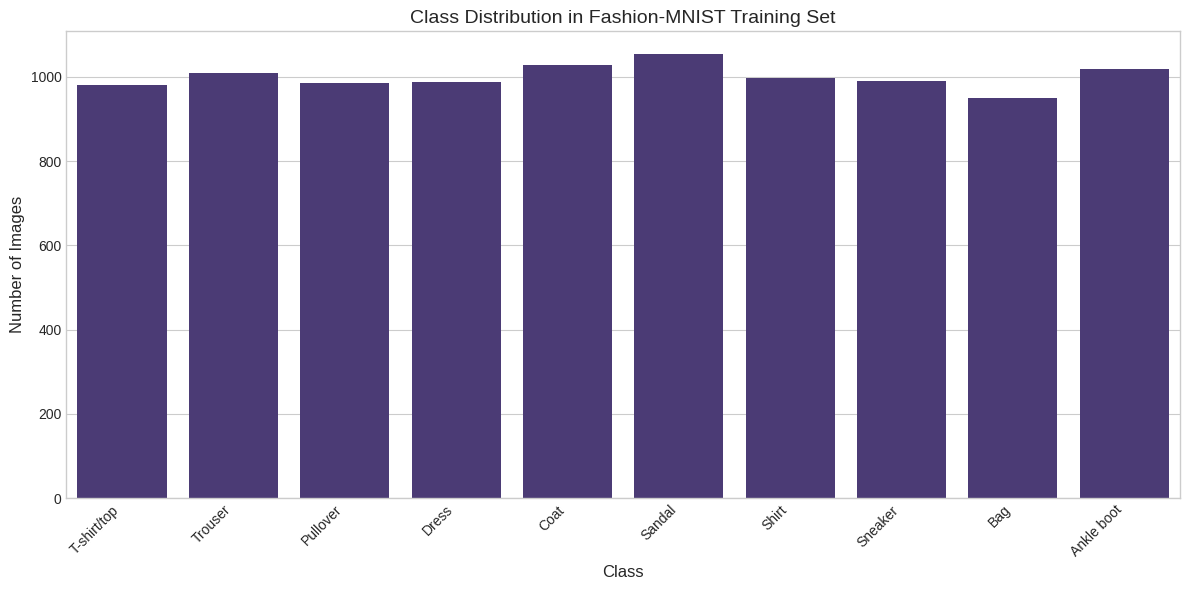

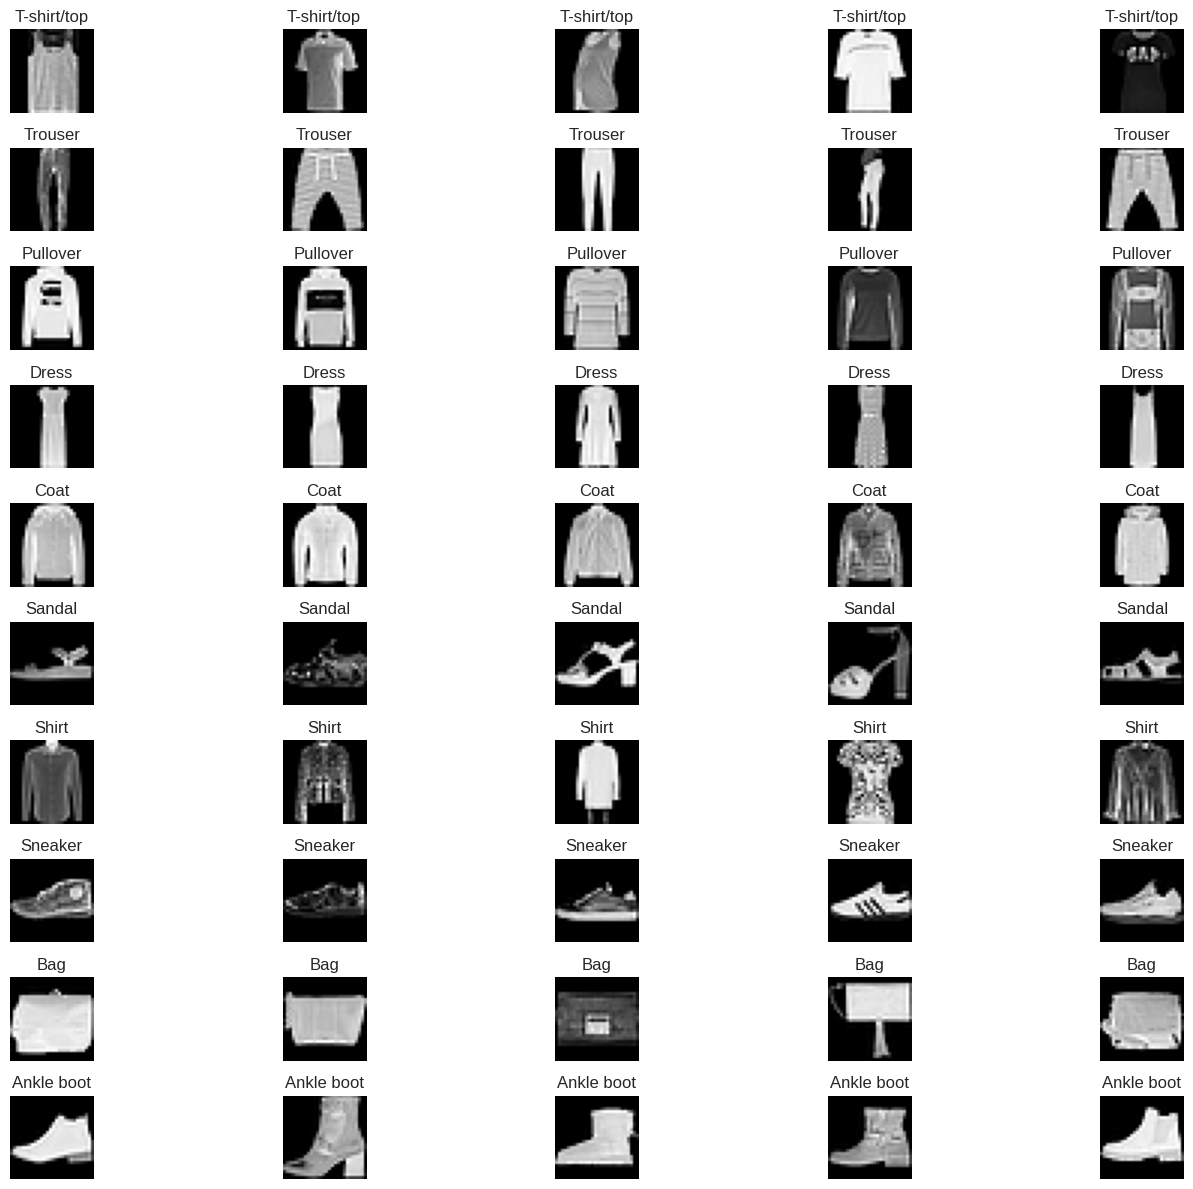

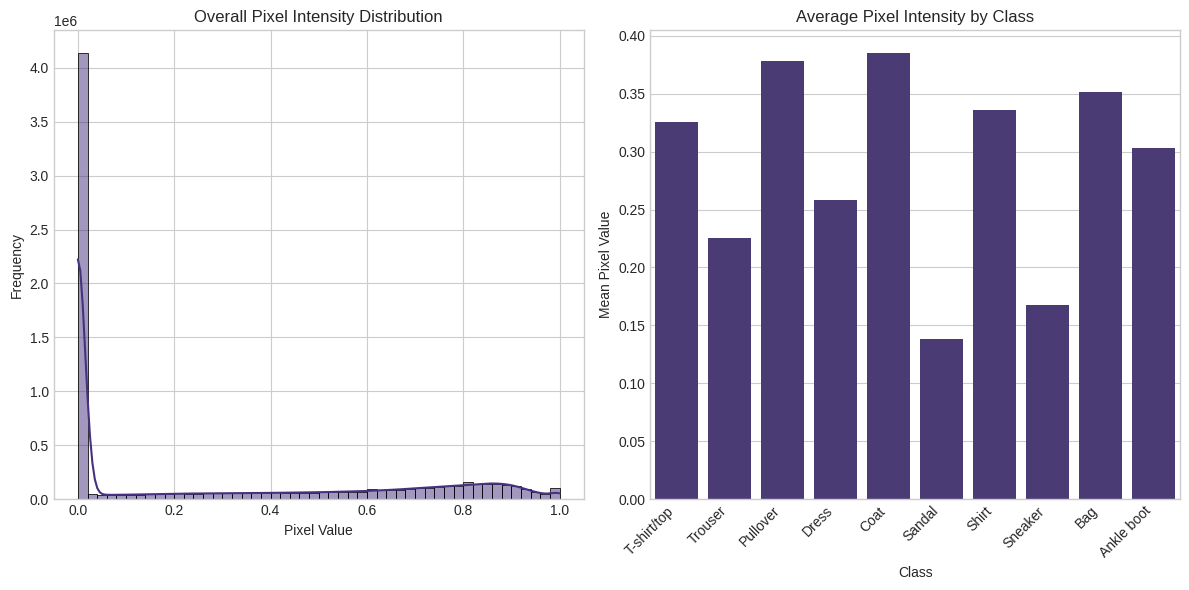

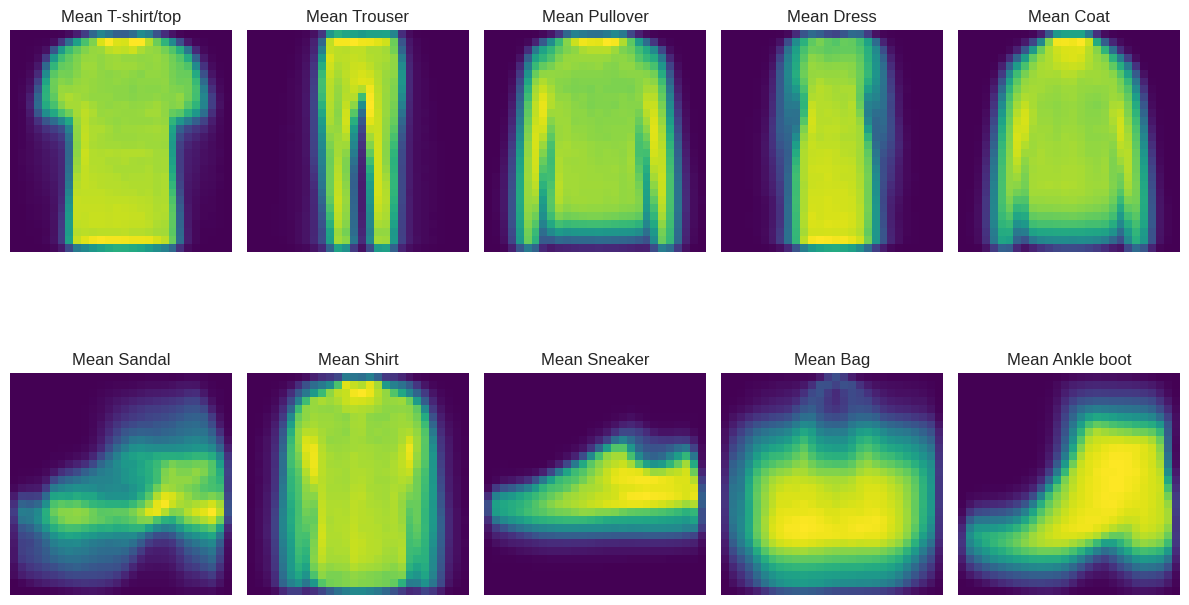

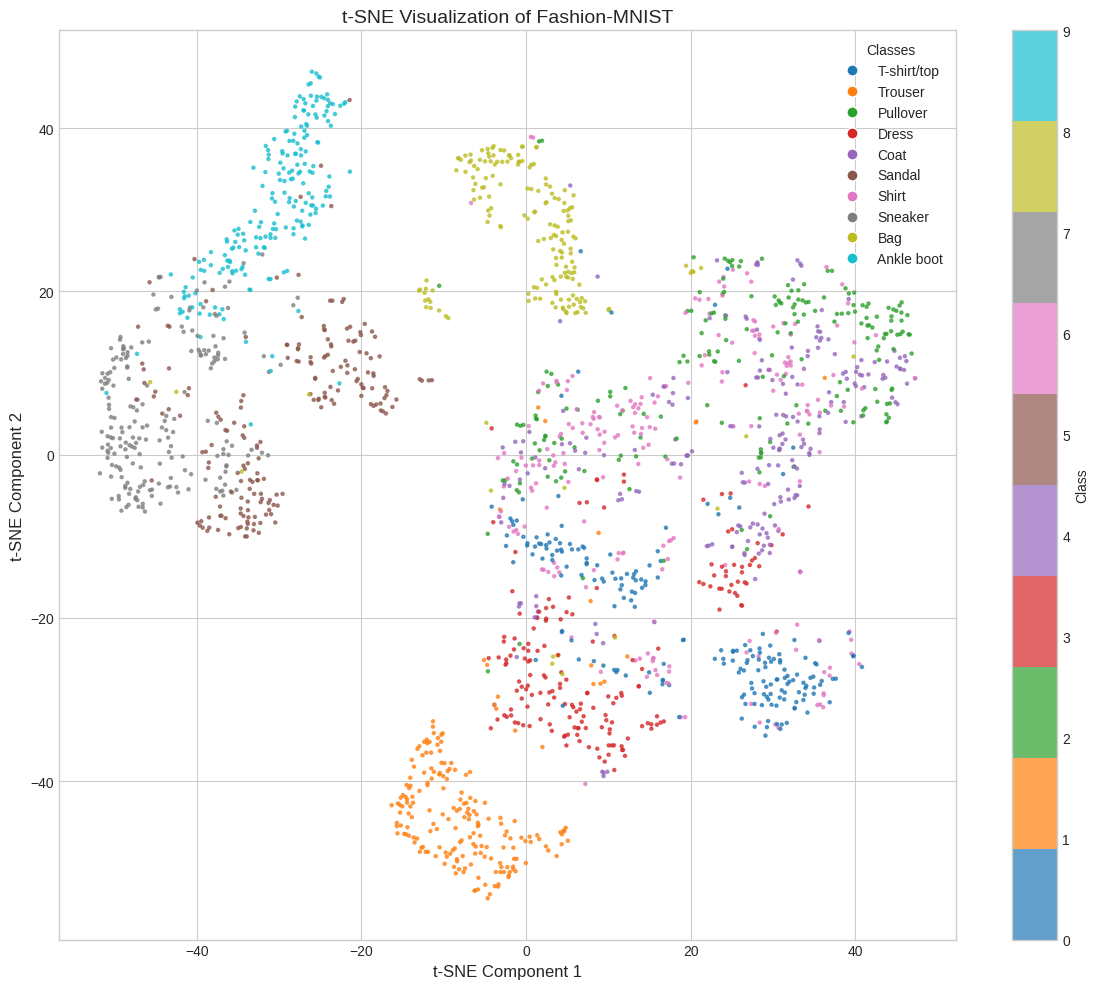

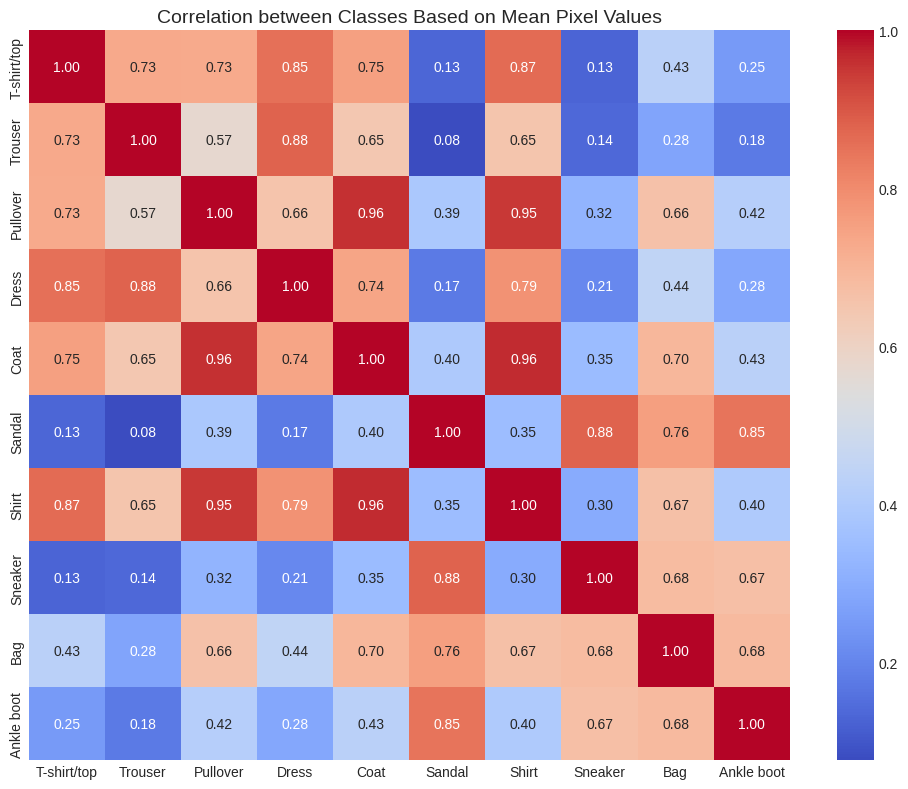

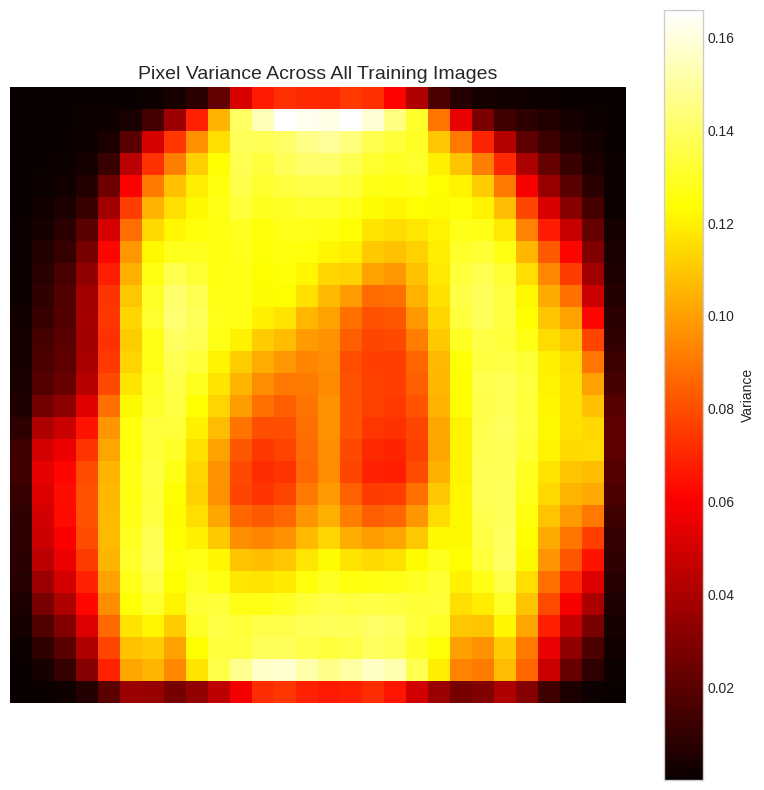

In [10]:
# 3. Visualizations

# 3.1 Class Distribution Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=[label_names[l] for l in unique_labels], y=counts)
plt.title('Class Distribution in Fashion-MNIST Training Set', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png')
print("\nClass distribution plot saved as 'class_distribution.png'")

# 3.2 Sample Images from each class
plt.figure(figsize=(15, 12))
for i in range(10):
    # Find indices for each class
    indices = np.where(train_labels == i)[0]

    # Display 5 random samples from each class
    for j in range(5):
        plt.subplot(10, 5, i*5 + j + 1)
        idx = np.random.choice(indices)
        plt.imshow(train_images[idx], cmap='gray')
        plt.title(f"{label_names[i]}")
        plt.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png')
print("Sample images saved as 'sample_images.png'")

# 3.3 Pixel Intensity Distribution
plt.figure(figsize=(12, 6))

# Overall pixel intensity distribution
plt.subplot(1, 2, 1)
pixel_values = train_images.flatten()
sns.histplot(pixel_values, bins=50, kde=True)
plt.title('Overall Pixel Intensity Distribution', fontsize=12)
plt.xlabel('Pixel Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Average pixel intensity per class
plt.subplot(1, 2, 2)
class_means = []
for i in range(10):
    class_images = train_images[train_labels == i]
    class_mean = class_images.mean()
    class_means.append(class_mean)

sns.barplot(x=[label_names[i] for i in range(10)], y=class_means)
plt.title('Average Pixel Intensity by Class', fontsize=12)
plt.xlabel('Class', fontsize=10)
plt.ylabel('Mean Pixel Value', fontsize=10)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('pixel_distributions.png')
print("Pixel intensity distributions saved as 'pixel_distributions.png'")

# 3.4 Mean Images per Class
plt.figure(figsize=(12, 8))
for i in range(10):
    # Get all images of class i
    class_images = train_images[train_labels == i]
    # Calculate mean image
    mean_image = np.mean(class_images, axis=0)

    plt.subplot(2, 5, i+1)
    plt.imshow(mean_image, cmap='viridis')
    plt.title(f"Mean {label_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('mean_images.png')
print("Mean images per class saved as 'mean_images.png'")

# 3.5 Dimensionality Reduction for Visualization
print("\nPerforming dimensionality reduction with PCA...")
# Flatten the images
flat_images = train_images.reshape(train_images.shape[0], -1)

# Apply PCA to reduce dimensionality to 50 components first (for faster t-SNE)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(flat_images)
print(f"Explained variance ratio with 50 PCA components: {sum(pca.explained_variance_ratio_):.4f}")

# Apply t-SNE on the PCA results
print("Applying t-SNE for visualization (this may take a while)...")
# Using a smaller subset for t-SNE to avoid long computation times
tsne_sample_size = min(2000, len(pca_result))
indices = np.random.choice(len(pca_result), tsne_sample_size, replace=False)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
tsne_result = tsne.fit_transform(pca_result[indices])
tsne_labels = train_labels[indices]

# Plot t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=tsne_labels,
                       cmap='tab10', alpha=0.7, s=5)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.title('t-SNE Visualization of Fashion-MNIST', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=scatter.cmap(scatter.norm(i)),
                              markersize=8, label=label_names[i])
                   for i in range(10)]
plt.legend(handles=legend_elements, title="Classes", loc="best")

plt.tight_layout()
plt.savefig('tsne_visualization.png')
print("t-SNE visualization saved as 'tsne_visualization.png'")

# 3.6 Correlation between classes based on pixel values
print("\nCalculating class correlations...")
class_means = np.zeros((10, 28*28))
for i in range(10):
    class_images = train_images[train_labels == i]
    class_means[i] = np.mean(class_images, axis=0).flatten()

correlation_matrix = np.corrcoef(class_means)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Correlation between Classes Based on Mean Pixel Values', fontsize=14)
plt.tight_layout()
plt.savefig('class_correlations.png')
print("Class correlation heatmap saved as 'class_correlations.png'")

# 3.7 Pixel Variance Analysis
pixel_variance = np.var(train_images, axis=0)
plt.figure(figsize=(8, 8))
plt.imshow(pixel_variance, cmap='hot')
plt.colorbar(label='Variance')
plt.title('Pixel Variance Across All Training Images', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('pixel_variance.png')
print("Pixel variance visualization saved as 'pixel_variance.png'")

In [ ]:
# 4. Summary Statistics by Class
print("\n--- Summary Statistics by Class ---")
for i in range(10):
    class_images = train_images[train_labels == i]
    print(f"\nClass {i} ({label_names[i]}):")
    print(f"  Number of samples: {len(class_images)}")
    print(f"  Mean pixel value: {class_images.mean():.4f}")
    print(f"  Std deviation: {class_images.std():.4f}")
    print(f"  Min pixel value: {class_images.min():.4f}")
    print(f"  Max pixel value: {class_images.max():.4f}")

print("\nExploratory Data Analysis complete!")


--- Summary Statistics by Class ---

Class 0 (T-shirt/top):
  Number of samples: 1003
  Mean pixel value: 0.3247
  Std deviation: 0.3491
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Class 1 (Trouser):
  Number of samples: 989
  Mean pixel value: 0.2224
  Std deviation: 0.3428
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Class 2 (Pullover):
  Number of samples: 989
  Mean pixel value: 0.3778
  Std deviation: 0.3571
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Class 3 (Dress):
  Number of samples: 1039
  Mean pixel value: 0.2576
  Std deviation: 0.3529
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Class 4 (Coat):
  Number of samples: 987
  Mean pixel value: 0.3905
  Std deviation: 0.3782
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Class 5 (Sandal):
  Number of samples: 1007
  Mean pixel value: 0.1341
  Std deviation: 0.2611
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Class 6 (Shirt):
  Number of samples: 964
  Mean pixel value: 0.3310
  S

**This is an extra code needed for uploading an image, comparte it with the existing classes and identify to which class it belongs.**

<ipython-input-11-6807bc4b6361>:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Getting representative features from the training dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━

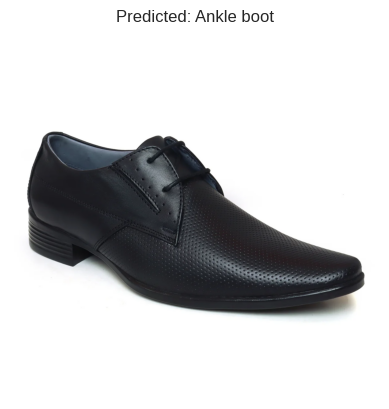

In [11]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from io import BytesIO
import requests
from PIL import Image # Import the Image module

# Load a pre-trained model for feature extraction
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def preprocess_image(img):
    """Preprocess image for feature extraction"""
    if isinstance(img, str):
        if img.startswith('http'):
            response = requests.get(img)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(img)

    # Convert to RGB if needed
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize and preprocess for MobileNetV2
    img = img.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def extract_features(img_array):
    """Extract features using pre-trained model"""
    # Predict features and remove the batch dimension
    return feature_extractor.predict(img_array)[0]

# Define label names for Fashion-MNIST (already defined earlier, restating for clarity in this block)
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


# Modify the function to use the correct dataset structure (labels instead of category)
def get_representative_features(dataset_split, n_samples=10):
    """Get representative features for each category using the 'label' column."""
    category_features = {}

    # Iterate through the unique labels (0 to 9)
    for label_int in range(10):
        # Get sample indices for this label
        # Assuming dataset_split is a Hugging Face Dataset object with 'label' column
        samples_indices = [i for i, l in enumerate(dataset_split['label']) if l == label_int]

        # Handle cases where a label might not be present in a small subset
        if not samples_indices:
            print(f"Warning: No samples found for label {label_int} ({label_names[label_int]}). Skipping.")
            continue

        # Select a random subset of indices
        sample_indices_subset = np.random.choice(samples_indices, min(n_samples, len(samples_indices)), replace=False)

        # Extract features for each sample in the subset
        features = []
        for idx in sample_indices_subset:
            sample = dataset_split[int(idx)] # Ensure index is int
            img = sample['image']

            # Ensure img is a PIL Image before preprocessing
            if not isinstance(img, Image.Image):
                 # If it's a numpy array, convert it to PIL Image first
                 img = Image.fromarray(img)

            img_array = preprocess_image(img)
            features.append(extract_features(img_array))

        # Average the features for this category
        if features: # Check if any features were extracted
            avg_features = np.mean(features, axis=0)
            category_features[label_names[label_int]] = avg_features # Store with label name
        else:
            print(f"Warning: No features extracted for label {label_int} ({label_names[label_int]}).")


    return category_features

# Get representative features for all categories using the training dataset split
# Using the training split as it's used in the EDA section
print("Getting representative features from the training dataset...")
category_features = get_representative_features(train_dataset)
print("Representative features obtained.")

def classify_new_image(img_path, category_features):
    """Classify a new image by comparing to category features"""
    # Preprocess the new image
    img_array = preprocess_image(img_path)

    # Extract features for the new image
    new_features = extract_features(img_array)

    # Calculate similarity with each category
    similarities = {}
    for category_name, features in category_features.items():
        # Ensure both feature vectors have the same shape for cosine_similarity
        # The feature_extractor.predict result has shape (1, features_dim)
        # The stored category features have shape (features_dim,) after averaging.
        # Need to ensure consistent shapes for cosine_similarity.
        # Let's reshape the category features to (1, features_dim) for comparison
        sim = cosine_similarity(new_features.reshape(1, -1), features.reshape(1, -1))
        similarities[category_name] = sim[0][0]

    # Get the most similar category
    if similarities: # Check if similarities dictionary is not empty
        predicted_category = max(similarities.items(), key=lambda x: x[1])[0]
    else:
        predicted_category = "Unknown" # Handle case with no categories

    return predicted_category, similarities

# Example usage:
# Upload an image (replace with your image path or URL)
# For local file: 'path/to/your/image.jpg'
# For URL: 'https://example.com/image.jpg'
img_path = '/content/sample_data/Shoe_formal.jpg'  # Change this to your image path

# Classify the image
# Ensure category_features is not empty before classifying
if category_features:
    predicted_category, similarities = classify_new_image(img_path, category_features)

    print(f"\nPredicted category: {predicted_category}")
    print("\nSimilarity scores:")
    # Sort similarities for better readability
    for category, score in sorted(similarities.items(), key=lambda x: x[1], reverse=True):
        print(f"{category}: {score:.4f}")

    # Display the uploaded image with prediction
    try:
        plt.figure()
        img = Image.open(img_path) if not img_path.startswith('http') else Image.open(BytesIO(requests.get(img_path).content))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_category}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

else:
    print("Could not generate category features. Classification skipped.")

Testing that it also says if this is for hot or cold weather.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Predicted clothing item: Ankle boot
Weather suitability: Cold

Confidence scores:
Cold weather items: 59.0%
Hot weather items: 41.0%

Detailed similarity scores:
Ankle boot: 0.4372 (Cold)
Sneaker: 0.3954 (Hot)
Sandal: 0.3518 (Hot)
T-shirt/top: 0.3413 (Hot)
Dress: 0.3357 (Hot)
Bag: 0.3306 (Cold)
Trouser: 0.3267 (Cold)
Pullover: 0.3261 (Cold)
Shirt: 0.3177 (Cold)
Coat: 0.3121 (Cold)


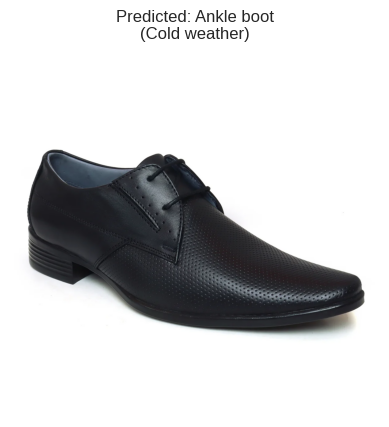

In [12]:
# Define weather categories based on Fashion-MNIST classes
cold_weather_items = ["Trouser", "Pullover", "Coat", "Shirt", "Ankle boot", "Bag"]
hot_weather_items = ["T-shirt/top", "Dress", "Sandal", "Sneaker"]

# Create a mapping from original classes to weather categories
weather_category_map = {
    "T-shirt/top": "Hot",
    "Trouser": "Cold",
    "Pullover": "Cold",
    "Dress": "Hot",
    "Coat": "Cold",
    "Sandal": "Hot",
    "Shirt": "Cold",
    "Sneaker": "Hot",
    "Bag": "Cold",
    "Ankle boot": "Cold"
}

def classify_weather_category(predicted_category, similarities):
    """Determine if the predicted item is for cold or hot weather"""
    # Get the weather category from our mapping
    weather_category = weather_category_map.get(predicted_category, "Unknown")

    # Calculate confidence scores for weather categories
    cold_score = sum(similarities[item] for item in cold_weather_items if item in similarities)
    hot_score = sum(similarities[item] for item in hot_weather_items if item in similarities)

    # Normalize scores to percentages
    total_score = cold_score + hot_score
    if total_score > 0:
        cold_percent = (cold_score / total_score) * 100
        hot_percent = (hot_score / total_score) * 100
    else:
        cold_percent = hot_percent = 0

    return weather_category, cold_percent, hot_percent

# Modify the example usage section to include weather classification
if category_features:
    predicted_category, similarities = classify_new_image(img_path, category_features)

    # Get weather classification
    weather_category, cold_percent, hot_percent = classify_weather_category(predicted_category, similarities)

    print(f"\nPredicted clothing item: {predicted_category}")
    print(f"Weather suitability: {weather_category}")
    print(f"\nConfidence scores:")
    print(f"Cold weather items: {cold_percent:.1f}%")
    print(f"Hot weather items: {hot_percent:.1f}%")

    print("\nDetailed similarity scores:")
    for category, score in sorted(similarities.items(), key=lambda x: x[1], reverse=True):
        print(f"{category}: {score:.4f} ({weather_category_map.get(category, 'Unknown')})")

    # Display the uploaded image with prediction
    try:
        plt.figure()
        img = Image.open(img_path) if not img_path.startswith('http') else Image.open(BytesIO(requests.get(img_path).content))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_category}\n({weather_category} weather)")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

else:
    print("Could not generate category features. Classification skipped.")

This part also shows when something is formal and when it is not.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

Predicted item: Ankle boot
• Weather suitability: Cold (Confidence: 59.0%)
• Formality: Formal (Confidence: 68.7%)

Detailed analysis:
Weather suitability confidence:
  Cold weather items: 59.0%
  Hot weather items: 41.0%

Formality confidence:
  Formal: 68.7%
  Casual: 31.3%

Similarity scores by item:
Ankle boot: 0.4372 (Cold/Formal)
Sneaker: 0.3954 (Hot/Casual)
Sandal: 0.3518 (Hot/Casual)
T-shirt/top: 0.3413 (Hot/Casual)
Dress: 0.3357 (Hot/Formal)
Bag: 0.3306 (Cold/Formal)
Trouser: 0.3267 (Cold/Formal)
Pullover: 0.3261 (Cold/Formal)
Shirt: 0.3177 (Cold/Formal)
Coat: 0.3121 (Cold/Formal)


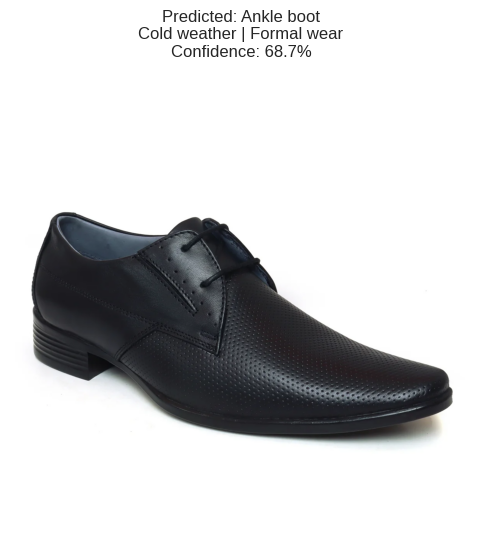

In [13]:
# Define categories with dual classification (weather + formality)
style_categories = {
    "T-shirt/top": {"weather": "Hot", "formality": "Casual"},
    "Trouser": {"weather": "Cold", "formality": "Formal"},
    "Pullover": {"weather": "Cold", "formality": "Formal"},
    "Dress": {"weather": "Hot", "formality": "Formal"},
    "Coat": {"weather": "Cold", "formality": "Formal"},
    "Sandal": {"weather": "Hot", "formality": "Casual"},
    "Shirt": {"weather": "Cold", "formality": "Formal"},
    "Sneaker": {"weather": "Hot", "formality": "Casual"},
    "Bag": {"weather": "Cold", "formality": "Formal"},
    "Ankle boot": {"weather": "Cold", "formality": "Formal"}
}

def classify_style(predicted_category, similarities):
    """Determine weather suitability and formality"""
    # Get the style attributes from our mapping
    style_info = style_categories.get(predicted_category, {"weather": "Unknown", "formality": "Unknown"})

    # Calculate confidence scores for weather categories
    cold_items = [k for k,v in style_categories.items() if v["weather"] == "Cold"]
    hot_items = [k for k,v in style_categories.items() if v["weather"] == "Hot"]

    cold_score = sum(similarities[item] for item in cold_items if item in similarities)
    hot_score = sum(similarities[item] for item in hot_items if item in similarities)

    # Calculate confidence scores for formality
    formal_items = [k for k,v in style_categories.items() if v["formality"] == "Formal"]
    casual_items = [k for k,v in style_categories.items() if v["formality"] == "Casual"]

    formal_score = sum(similarities[item] for item in formal_items if item in similarities)
    casual_score = sum(similarities[item] for item in casual_items if item in similarities)

    # Normalize scores to percentages
    total_weather = cold_score + hot_score
    total_formality = formal_score + casual_score

    weather_percent = {
        "Cold": (cold_score / total_weather * 100) if total_weather > 0 else 0,
        "Hot": (hot_score / total_weather * 100) if total_weather > 0 else 0
    }

    formality_percent = {
        "Formal": (formal_score / total_formality * 100) if total_formality > 0 else 0,
        "Casual": (casual_score / total_formality * 100) if total_formality > 0 else 0
    }

    return style_info, weather_percent, formality_percent

# Update the example usage section
if category_features:
    predicted_category, similarities = classify_new_image(img_path, category_features)

    # Get style classification
    style_info, weather_percent, formality_percent = classify_style(predicted_category, similarities)

    print(f"\nPredicted item: {predicted_category}")
    print(f"• Weather suitability: {style_info['weather']} (Confidence: {weather_percent[style_info['weather']]:.1f}%)")
    print(f"• Formality: {style_info['formality']} (Confidence: {formality_percent[style_info['formality']]:.1f}%)")

    print("\nDetailed analysis:")
    print("Weather suitability confidence:")
    print(f"  Cold weather items: {weather_percent['Cold']:.1f}%")
    print(f"  Hot weather items: {weather_percent['Hot']:.1f}%")

    print("\nFormality confidence:")
    print(f"  Formal: {formality_percent['Formal']:.1f}%")
    print(f"  Casual: {formality_percent['Casual']:.1f}%")

    print("\nSimilarity scores by item:")
    for category, score in sorted(similarities.items(), key=lambda x: x[1], reverse=True):
        print(f"{category}: {score:.4f} ({style_categories[category]['weather']}/{style_categories[category]['formality']})")

    # Display the uploaded image with prediction
    try:
        plt.figure(figsize=(8, 6))
        img = Image.open(img_path) if not img_path.startswith('http') else Image.open(BytesIO(requests.get(img_path).content))
        plt.imshow(img)
        plt.title(
            f"Predicted: {predicted_category}\n"
            f"{style_info['weather']} weather | {style_info['formality']} wear\n"
            f"Confidence: {max(weather_percent[style_info['weather']], formality_percent[style_info['formality']]):.1f}%",
            pad=20
        )
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

else:
    print("Could not generate category features. Classification skipped.")

Let's have it allow you to upoload 10 images as part of your wardrove.

In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# Initialize wardrobe storage
wardrobe = []

# File upload widget
uploader = widgets.FileUpload(
    multiple=True,
    description='Upload Wardrobe',
    accept='image/*',
    disabled=False
)

# Style selection widgets
weather_choice = widgets.RadioButtons(
    options=['Hot', 'Cold'],
    description='Weather:',
    disabled=False
)

occasion_choice = widgets.RadioButtons(
    options=['Casual', 'Formal'],
    description='Occasion:',
    disabled=False
)

recommend_button = widgets.Button(description="Get Outfit Recommendations")
out = widgets.Output()

def handle_upload(change):
    global wardrobe
    wardrobe = []

    for name, file_info in uploader.value.items():
        img_data = file_info['content']
        img = Image.open(BytesIO(img_data))

        # Classify and store each item
        img_array = preprocess_image(img)
        features = extract_features(img_array)

        # Find most similar category
        similarities = {}
        for category, cat_features in category_features.items():
            sim = cosine_similarity(features.reshape(1, -1), cat_features.reshape(1, -1))
            similarities[category] = sim[0][0]

        predicted_category = max(similarities.items(), key=lambda x: x[1])[0]
        style_info = style_categories[predicted_category]

        wardrobe.append({
            'image': img,
            'category': predicted_category,
            'weather': style_info['weather'],
            'formality': style_info['formality'],
            'similarity': similarities[predicted_category]
        })

    with out:
        clear_output()
        print(f"✅ Wardrobe updated with {len(wardrobe)} items")
        display_wardrobe_grid()

def display_wardrobe_grid():
    plt.figure(figsize=(15, 8))
    for i, item in enumerate(wardrobe[:10]):  # Show first 10 items
        plt.subplot(2, 5, i+1)
        plt.imshow(item['image'])
        plt.title(f"{item['category']}\n{item['weather']}/{item['formality']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def recommend_outfit(b):
    with out:
        clear_output()

        # Filter wardrobe based on selections
        filtered = [item for item in wardrobe
                   if item['weather'] == weather_choice.value
                   and item['formality'] == occasion_choice.value]

        if not filtered:
            print("No matching items in wardrobe for these criteria")
            return

        # Sort by confidence
        filtered.sort(key=lambda x: x['similarity'], reverse=True)

        # Recommend combinations
        print(f"✨ Recommended {weather_choice.value} weather, {occasion_choice.value} outfits:")

        # Upper + Lower + Footwear combinations
        upper_types = ['T-shirt/top', 'Pullover', 'Dress', 'Coat', 'Shirt']
        lower_types = ['Trouser']
        footwear_types = ['Sandal', 'Sneaker', 'Ankle boot']

        # Get available items
        uppers = [item for item in filtered if item['category'] in upper_types]
        lowers = [item for item in filtered if item['category'] in lower_types]
        footwear = [item for item in filtered if item['category'] in footwear_types]
        accessories = [item for item in filtered if item['category'] == 'Bag']

        # Show top 3 combinations
        for i in range(min(3, len(uppers))):
            print(f"\nOutfit Option {i+1}:")

            # Dress is a complete outfit
            if uppers[i]['category'] == 'Dress':
                display_item(uppers[i], "Dress")
                if footwear and i < len(footwear):
                    display_item(footwear[i], "Footwear")
                continue

            # Upper + Lower combination
            display_item(uppers[i], "Top")
            if lowers and i < len(lowers):
                display_item(lowers[i], "Bottom")
            if footwear and i < len(footwear):
                display_item(footwear[i], "Footwear")
            if accessories and i < len(accessories):
                display_item(accessories[i], "Accessory")

def display_item(item, item_type):
    plt.figure(figsize=(3, 3))
    plt.imshow(item['image'])
    plt.title(f"{item_type}: {item['category']}")
    plt.axis('off')
    plt.show()

# Set up UI
uploader.observe(handle_upload, names='value')
recommend_button.on_click(recommend_outfit)

display(widgets.VBox([
    widgets.HTML("<h2>Step 1: Upload Your Wardrobe (10 items max)</h2>"),
    uploader,
    widgets.HTML("<h2>Step 2: Select Preferences</h2>"),
    weather_choice,
    occasion_choice,
    recommend_button,
    out
]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
